# Generation of analysis data for tests

In [3]:
from numba import set_num_threads
set_num_threads(2)

import gromacs
import mdtraj as md
import mdenvironment as mde

print(f'GROMACS version used to generate data: {gromacs.release}')
print(f'MDTraj version used to generate data: {md.version.full_version}')
print(f'MDEnvironment version used to run this notebook: {mde.__version__}')

Numba version  0.55.0  detected. MDEnvironment will default to optimization using Numba.

Numba currently using 2 threads with shared memory! Reduce this number by passing "numba.set_num_threads(x)" with an appropriate integer value.



/opt/homebrew/anaconda3/envs/MDEnvironment/lib/python3.9/site-packages/numba/core/lowering.py:104: NumbaWarning: Could not find source for function: <function __numba_parfor_gufunc_0x19272fe50 at 0x1927425e0>
  warnings.warn(NumbaWarning(msg))
/opt/homebrew/anaconda3/envs/MDEnvironment/lib/python3.9/site-packages/numba/core/lowering.py:104: NumbaWarning: Could not find source for function: <function __numba_parfor_gufunc_0x190a73610 at 0x19274f700>
  warnings.warn(NumbaWarning(msg))
/opt/homebrew/anaconda3/envs/MDEnvironment/lib/python3.9/site-packages/numba/core/lowering.py:104: NumbaWarning: Could not find source for function: <function __numba_parfor_gufunc_0x19273cac0 at 0x192b6f820>
  warnings.warn(NumbaWarning(msg))
/opt/homebrew/anaconda3/envs/MDEnvironment/lib/python3.9/site-packages/numba/core/lowering.py:104: NumbaWarning: Could not find source for function: <function __numba_parfor_gufunc_0x19273dc10 at 0x192b6ff70>
  warnings.warn(NumbaWarning(msg))
/opt/homebrew/anaconda3/

GROMACS version used to generate data: 2021.5-Homebrew
MDTraj version used to generate data: 1.9.7
MDEnvironment version used to run this notebook: 0.0.1


In [4]:
infiles = 'nacl_box'
refs = ['O', 'NA', 'CL']
sel = 'O'
n_bins = 120
r_max = 1.2  # 1.2 nm
bin_width = r_max / n_bins
gmx_rmax = r_max + bin_width / 2

In [5]:
run = {
    'GROMACS': False,
    'MDTraj': False,
    'MDEnvironment': True
}

## GROMACS RDF

Run the following command in GROMACS (but here using the GROMACS-wrapper):

```bash
gmx rdf -f nacl_box -s nacl_box -n nacl_box -o rdf.xvg -ref <reference_group> -sel <selection_group>
```

In [6]:
if run['GROMACS']:
    import gromacs
    for ref in refs:
        %time gromacs.g_rdf('nobackup', f=infiles, s=infiles, n=infiles, ref=ref, sel=sel,\
                o=f'{ref}_rdf.xvg', cut=bin_width/2, rmax=gmx_rmax, bin=bin_width)

In [7]:
from gromacs.formats import XVG
import pandas as pd

gmx_rdfs = []
for ref in refs:
    rdf_df = XVG(f'{ref}_rdf.xvg').to_df()
    rdf_df.rename(columns={sel: f'{ref}-{sel}'}, inplace=True)
    rdf_df.set_index('r (nm)', inplace=True)
    gmx_rdfs.append(rdf_df)

gmx_rdf = pd.concat(gmx_rdfs, axis=1)
gmx_rdf

,O-O,NA-O,CL-O
r (nm),,,
0.00,0.000,0.000,0.000
0.01,0.000,0.000,0.000
0.02,0.000,0.000,0.000
0.03,0.000,0.000,0.000
0.04,0.000,0.000,0.000
...,...,...,...
1.16,1.005,1.041,0.964
1.17,1.003,1.016,0.995
1.18,1.003,1.051,1.011


In [8]:
import numpy as np

gmx_rdf = {
    ref: np.loadtxt(f'{ref}_rdf.xvg', comments=['#', '@'], unpack=True) for ref in refs
}

gmx_r = {
    ref: gmx_rdf[ref][0] for ref in refs
}

gmx_gr = {
    ref: gmx_rdf[ref][1] for ref in refs
}

## RDF using MDTraj


In [9]:
if run['MDTraj'] or run['MDEnvironment']:
    import mdtraj as md

    top = md.load_topology('nacl_box.gro')
    traj = md.load('nacl_box.xtc', top=top)
    # groups = {g: traj.top.select(f'name {g}') for g in ['O', 'NA', 'CL', 'H']}
    groups = {g: traj.top.select(f'name {g}') for g in ['O', 'NA', 'CL']}

    pairs = {}
    for ref in refs:
        pairs[ref] = traj.top.select_pairs(groups[ref], groups[sel])

In [10]:
import numpy as np

mdtraj_r = {}
mdtraj_gr = {}
if run['MDTraj']:
    for ref in refs:
        %time r, gr = md.compute_rdf(traj, pairs=pairs[ref], periodic=True, opt=True, n_bins=n_bins,\
                r_range=(0, r_max))
        np.savetxt(f'{ref}_mdtraj_r.txt', r)
        np.savetxt(f'{ref}_mdtraj_gr.txt', gr)
        mdtraj_r[ref] = r
        mdtraj_gr[ref] = gr

else:
    for ref in refs:
        mdtraj_r[ref] = np.loadtxt(f'{ref}_mdtraj_r.txt')
        mdtraj_gr[ref] = np.loadtxt(f'{ref}_mdtraj_gr.txt')

## RDF from MDEnvironment using the `grt` time-resolved RDF method
We'll just average over the time windows to give us the same result as the static RDF over the whole trajectory.

In [14]:
mdenv_r_ortho = {}
mdenv_gr_ortho = {}
if run['MDEnvironment']:
    from numba import set_num_threads
    set_num_threads(2)
    import mdenvironment as mde

    for ref in refs:
        r, grt = mde.trrdf('nacl_box.xtc', groups[ref], groups[sel], pbc='ortho', opt=True, top=top,
                         n_windows=10, window_size=20, stride=1, skip=0, r_range=(0.0, r_max), nbins=n_bins)

        np.savetxt(f'{ref}_mdenv_r.txt', r)
        gr = grt.mean(axis=(0,1,2))
        np.savetxt(f'{ref}_mdenv_gr.txt', gr)
        mdenv_r_ortho[ref] = r
        mdenv_gr_ortho[ref] = gr

else:
    for ref in refs:
        mdenv_r_ortho[ref] = np.loadtxt(f'{ref}_mdenv_r.txt')
        mdenv_gr_ortho[ref] = np.loadtxt(f'{ref}_mdenv_gr.txt')

Progress over trajectory:   0%|          | 0/10 [00:00<?, ?it/s]/Users/emiledebruyn/ownCloud/darbeit/MDEnvironment/mdenvironment/time_resolved_rdf/jit/add_distribution_function_time_slice.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_jit_append_grts_ortho_mic" failed type inference due to: Invalid use of type(CPUDispatcher(<function _compute_grt_numba at 0x18f7f41f0>)) with parameters (array(float32, 3d, A), array(float32, 1d, C), UniTuple(float64 x 2), int64, bool)

During: resolving callee type: type(CPUDispatcher(<function _compute_grt_numba at 0x18f7f41f0>))
During: typing of call at /Users/emiledebruyn/ownCloud/darbeit/MDEnvironment/mdenvironment/time_resolved_rdf/jit/add_distribution_function_time_slice.py (12)


File "../../mdenvironment/time_resolved_rdf/jit/add_distribution_function_time_slice.py", line 12:
def _jit_append_grts_ortho_mic(g_rts, n, xyz, g1, g2, g1_lens, g2_lens, cuvec, cuvol, r_range, nbins, raw_coun

In [16]:
mdenv_r_gen = {}
mdenv_gr_gen = {}
if run['MDEnvironment']:
    from numba import set_num_threads
    set_num_threads(2)
    import mdenvironment as mde

    for ref in refs:
        r, grt = mde.trrdf('nacl_box.xtc', groups[ref], groups[sel], pbc='general', opt=True, top=top,
                         n_windows=10, window_size=20, stride=1, skip=0, r_range=(0.0, r_max), nbins=n_bins)

        np.savetxt(f'{ref}_mdenv_r.txt', r)
        gr = grt.mean(axis=(0,1,2))
        np.savetxt(f'{ref}_mdenv_gr.txt', gr)
        mdenv_r_gen[ref] = r
        mdenv_gr_gen[ref] = gr

else:
    for ref in refs:
        mdenv_r_gen[ref] = np.loadtxt(f'{ref}_mdenv_r.txt')
        mdenv_gr_gen[ref] = np.loadtxt(f'{ref}_mdenv_gr.txt')

Progress over trajectory:   0%|          | 0/10 [00:00<?, ?it/s]/Users/emiledebruyn/ownCloud/darbeit/MDEnvironment/mdenvironment/time_resolved_rdf/jit/add_distribution_function_time_slice.py:16: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_jit_append_grts_general_mic" failed type inference due to: Invalid use of type(CPUDispatcher(<function _compute_grt_numba at 0x18da4e0d0>)) with parameters (array(float32, 3d, A), array(float32, 1d, C), UniTuple(float64 x 2), int64, bool)

During: resolving callee type: type(CPUDispatcher(<function _compute_grt_numba at 0x18da4e0d0>))
During: typing of call at /Users/emiledebruyn/ownCloud/darbeit/MDEnvironment/mdenvironment/time_resolved_rdf/jit/add_distribution_function_time_slice.py (21)


File "../../mdenvironment/time_resolved_rdf/jit/add_distribution_function_time_slice.py", line 21:
def _jit_append_grts_general_mic(g_rts, n, xyz, g1, g2, g1_lens, g2_lens, cuvec, cuvol, r_range, nbins, raw

## RDF from MDEnvironment using the `Grt` van Hove function (VHF) method for the distinct part (excluding self-correlation)
To check the correct behaviour, at least with respect to the norm, we can put windows of size 1 (frame) over the whole
trajectory, thus giving us the static RDF over the whole trajectory.

In [11]:
vhf_r_ortho = {}
vhf_gr_ortho = {}
if run['MDEnvironment']:
    from numba import set_num_threads
    set_num_threads(2)
    import mdenvironment as mde

    for ref in refs:
        r, Gs, Gd = mde.vanhove('nacl_box.xtc', groups[ref], groups[sel], pbc='ortho', opt=True, top=top,
                              n_windows=200, window_size=1, stride=1, skip=0, r_range=(0.0, r_max), nbins=n_bins)

        np.savetxt(f'{ref}_vhf_r.txt', r)
        gr = Gd.mean(axis=(0,1,2))
        np.savetxt(f'{ref}_vhf_gr.txt', gr)
        vhf_r_ortho[ref] = r
        vhf_gr_ortho[ref] = gr

else:
    for ref in refs:
        vhf_r_ortho[ref] = np.loadtxt(f'{ref}_vhf_r.txt')
        vhf_gr_ortho[ref] = np.loadtxt(f'{ref}_vhf_gr.txt')

Progress over trajectory: 100%|██████████| 200/200 [00:00<00:00, 956.34it/s]


In [12]:
vhf_r_gen = {}
vhf_gr_gen = {}
if run['MDEnvironment']:
    from numba import set_num_threads
    set_num_threads(2)
    import mdenvironment as mde

    for ref in refs:
        r, Gs, Gd = mde.vanhove('nacl_box.xtc', groups[ref], groups[sel], pbc='general', opt=True, top=top,
                              n_windows=200, window_size=1, stride=1, skip=0, r_range=(0.0, r_max), nbins=n_bins)

        np.savetxt(f'{ref}_vhf_r.txt', r)
        gr = Gd.mean(axis=(0,1,2))
        np.savetxt(f'{ref}_vhf_gr.txt', gr)
        vhf_r_gen[ref] = r
        vhf_gr_gen[ref] = gr

else:
    for ref in refs:
        vhf_r_gen[ref] = np.loadtxt(f'{ref}_vhf_r.txt')
        vhf_gr_gen[ref] = np.loadtxt(f'{ref}_vhf_gr.txt')

Progress over trajectory: 100%|██████████| 200/200 [00:01<00:00, 190.35it/s]


## Plot results and differences
We'll see that due to the binning, the values from GROMACS will differ slightly. MDEnvironment's functions should be
identical to those given by MDTraj.

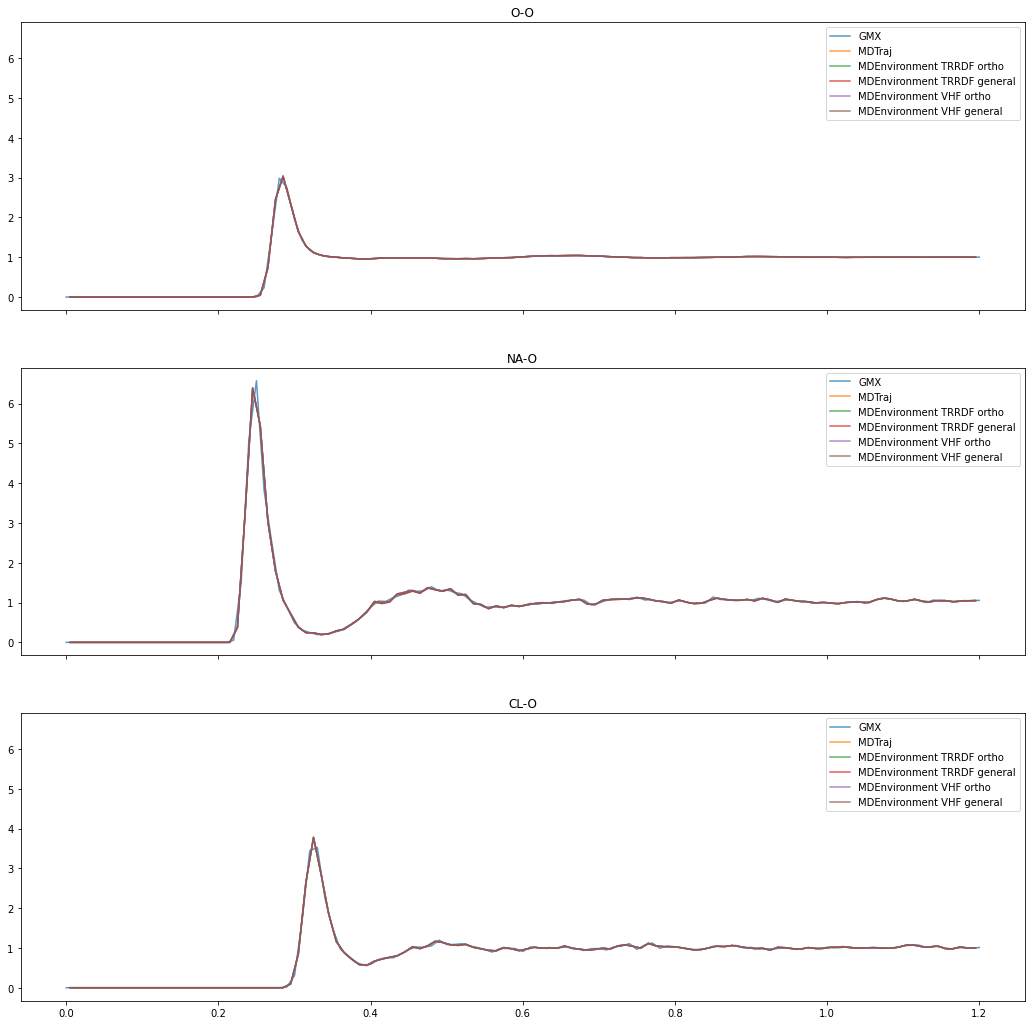

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(18,18), sharex=True, sharey=True)

for i, ref in enumerate(refs):
    axes[i].set_title(f'{ref}-{sel}')
    axes[i].plot(gmx_r[ref], gmx_gr[ref], label=f'GMX', alpha=.75)
    axes[i].plot(mdtraj_r[ref], mdtraj_gr[ref], label=f'MDTraj', alpha=.75)
    axes[i].plot(mdenv_r_ortho[ref], mdenv_gr_ortho[ref], label=f'MDEnvironment TRRDF ortho', alpha=.75)
    axes[i].plot(mdenv_r_ortho[ref], mdenv_gr_ortho[ref], label=f'MDEnvironment TRRDF general', alpha=.75)
    axes[i].plot(vhf_r_ortho[ref], vhf_gr_ortho[ref], label=f'MDEnvironment VHF ortho', alpha=.75)
    axes[i].plot(vhf_r_gen[ref], vhf_gr_gen[ref], label=f'MDEnvironment VHF general', alpha=.75)
    axes[i].legend()

## Numerical comparison
Let's check if the data is truly identical within numerical precision, or an acceptable deviation.

In [ ]:
def compare_arrays(a, b, rtol=5e-2):
    try:
        np.testing.assert_allclose(a, b, rtol=rtol)
        print(f'All elements match within a relative tolerance of {rtol:.2%}!')
    except AssertionError as err:
        print(err)

### MDTraj vs GROMACS

In [ ]:
for ref in refs:
    print(f'Comparison for {ref}-{sel} pairs:')
    compare_arrays(mdtraj_gr[ref], gmx_gr[ref][1:])
    print('\n')

### MDTraj vs TRRDF

In [ ]:
for ref in refs:
    print(f'Comparison for {ref}-{sel} pairs:')
    compare_arrays(mdtraj_gr[ref], mdenv_gr[ref])
    print('\n')

### MDTraj vs VHF

In [ ]:
for ref in refs:
    print(f'Comparison for {ref}-{sel} pairs:')
    compare_arrays(mdtraj_gr[ref], vhf_gr[ref])
    print('\n')


### TRRDF vs VHF

In [ ]:
for ref in refs:
    print(f'Comparison for {ref}-{sel} pairs:')
    compare_arrays(mdenv_gr[ref], vhf_gr[ref], rtol=1e-3)
    print('\n')

## Trapezoid integration

In [ ]:
def print_trapz(a, name):
    print(f'Integral of {name}: {np.trapz(a)}')

for ref in refs:
    print(f'Comparison for {ref}-{sel} pairs:')
    print_trapz(gmx_gr[ref], 'gmx rdf')
    print_trapz(mdtraj_gr[ref], 'MDTraj compute_rdf')
    print_trapz(mdenv_gr[ref], 'trrdf')
    print_trapz(vhf_gr[ref], 'vanhove')
    print('\n')